In [1]:
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Urban Drone Demo
## Model Overview
The drone model is defined in `drone_mdl_urban.py`, along with some visualization functions.

In [2]:
from drone_mdl_urban import Drone

In [3]:
mdl = Drone()

This is the model structure:

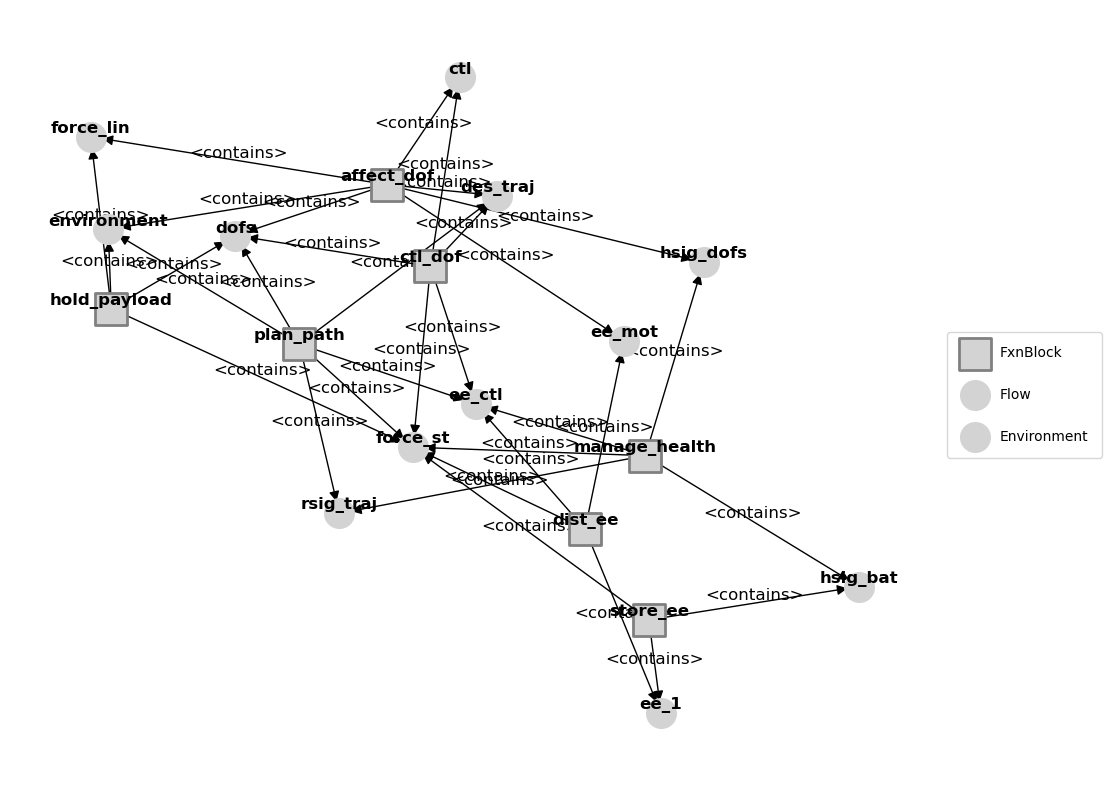

In [4]:
mg = an.graph.ModelGraph(mdl)
fig, ax = mg.draw()

We can also view the grid environment using methods in the `analyze.show` module:

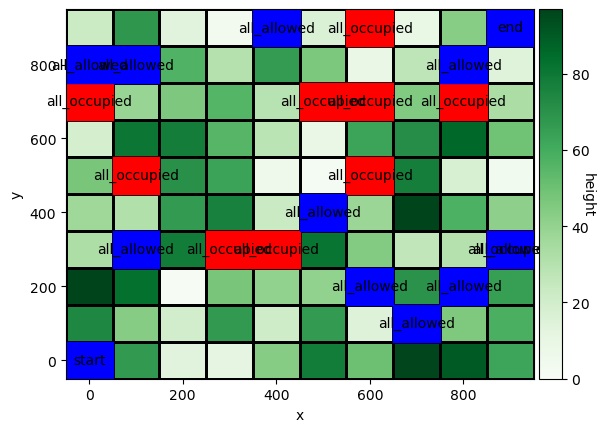

In [5]:
fig, ax = an.show.coord(mdl.flows['environment'].c, "height",
                        collections={"all_occupied": {"color": "red"},
                                     "all_allowed": {"color": "blue"},
                                     "start": {"color": "blue"},
                                     "end": {"color": "blue"}})

Which shows the Start, End, and allowed/unsafe locations in the 1000x1000-m grid. In this display, line thickness corresponds to building height, and hatching corresponds to whether or not the space is occupied. We can also display this using `show.coord3d`:

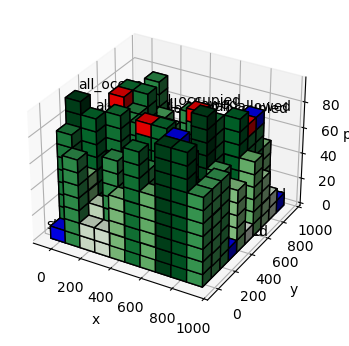

In [6]:
fig, ax = an.show.coord3d(mdl.flows['environment'].c, "height",
                        collections={"all_occupied": {"color": "red"},
                                     "all_allowed": {"color": "blue"},
                                     "start": {"color": "blue"},
                                     "end": {"color": "blue"}})

## Nominal Simulation

Below we show how this drone performs in the nominal scenario.

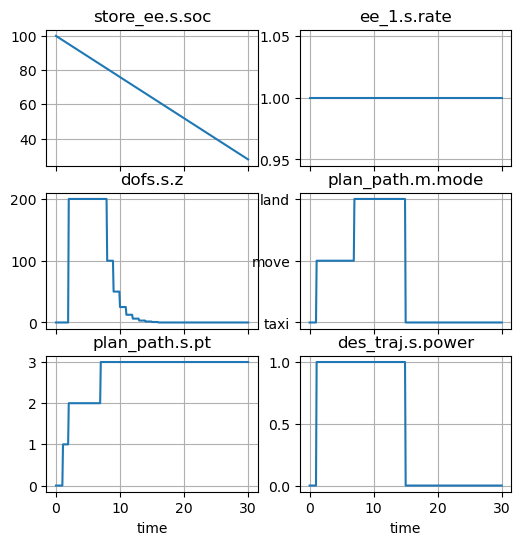

In [7]:
results_nom, hist_nom =propagate.nominal(mdl)
fig, axs = an.plot.hist(hist_nom, "store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

As shown, the flight ends fairly quickly (in 10 minutes), with the drone successively proceeding through points in the flight plan.

We can also view this flightpath in 3-d space using `show.trajectories`:

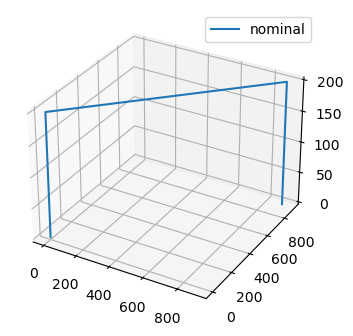

In [8]:
fig, ax = an.show.trajectories(hist_nom, 'dofs.s.x', 'dofs.s.y', 'dofs.s.z')

Trajectory plots can be overlaid on top of environment plots. In this case, we defined the method `plot_env_with_traj` and `plot_env_with_traj3` for this case.

In [9]:
from drone_mdl_urban import plot_env_with_traj, plot_env_with_traj3d


(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

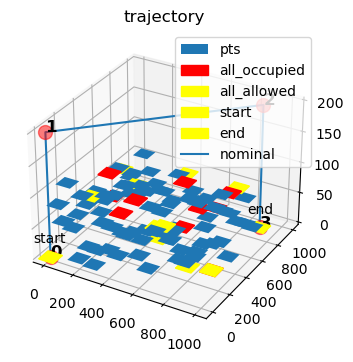

In [10]:
plot_env_with_traj3d(hist_nom, mdl)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

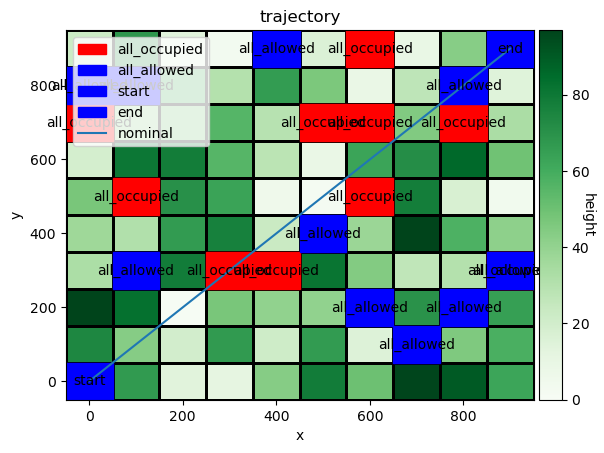

In [11]:
plot_env_with_traj(hist_nom, mdl)

As shown, this is a rather simple straight-line path. If we wanted a more complex scenario, we could make the path more complex by adding multiple destinations or planning the path based on allowed flight/landing locations.

As it is, we may also want to adjust the timestep/speed to get more resolution, since the drone only has a few discrete timesteps in the air.

The results for the simulation are:

In [12]:
results_nom

endclass: 
--rate:                              1.0
--cost:                              0.0
--expected cost:                     0.0
--repcost:                             0
--unsafe_flight_time:                  0
--body_strikes:                      0.0
--head_strikes:                      0.0
--property_restrictions:               0
--safecost:                          0.0
--landcost:                            0
--p_safety:                          0.0
--severities: {'hazardous': 0.0, 'minor': 1.0}

## Resilience model
A number of different faults have been implemented in the system.

For example, here we inject a mechanical fault in the left-rear rotor during flight:

In [13]:
mdl.fxns['affect_dof'].m.faultmodes

{'lf_short': Fault(dist=0.1, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_openc': Fault(dist=0.1, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_ctlup': Fault(dist=0.2, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_ctldn': Fault(dist=0.2, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_ctlbreak': Fault(dist=0.2, oppvect=[1.0], rcost=1000, probtype='rate', units='hr'),
 'lf_mechbreak': Fault(dist=0.1, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_mechfriction': Fault(dist=0.05, oppvect=[1.0], rcost=500, probtype='rate', units='hr'),
 'lf_propwarp': Fault(dist=0.01, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_propstuck': Fault(dist=0.02, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lf_propbreak': Fault(dist=0.03, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lr_short': Fault(dist=0.1, oppvect=[1.0], rcost=200, probtype='rate', units='hr'),
 'lr_openc': Fault(dist=0.1, oppvec

In [14]:
results_fault, hist_fault =propagate.one_fault(mdl, "affect_dof", "lr_mechbreak", time=2.0)

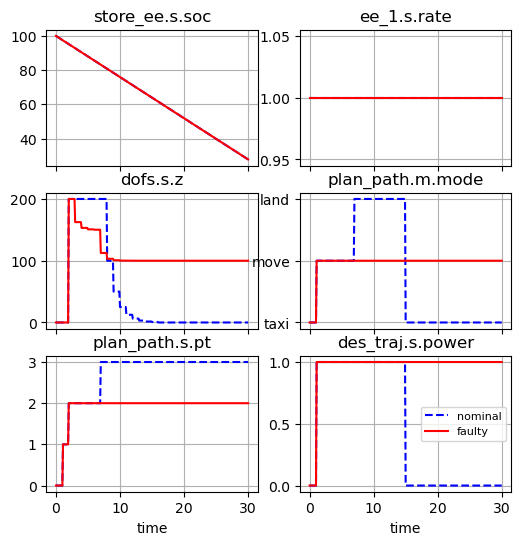

In [15]:
fig, axs = an.plot.hist(hist_fault, "store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

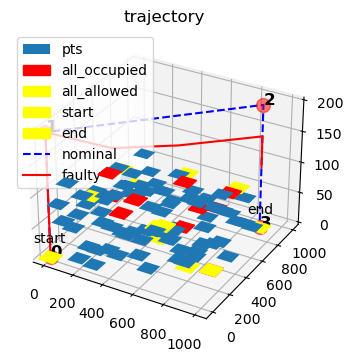

In [16]:
plot_env_with_traj3d(hist_fault, mdl)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

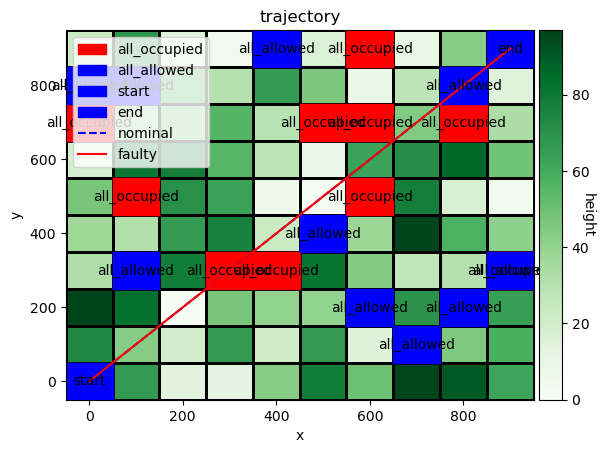

In [17]:
plot_env_with_traj(hist_fault, mdl)

In [18]:
results_fault

endclass.rate:        0.5016666666666667
endclass.cost:                   28600.0
endclass.expected cost: 1434766666.6666667
endclass.repcost:                    500
endclass.unsafe_flight_time:         281
endclass.body_strikes:               0.0
endclass.head_strikes:               0.0
endclass.property_restrictions:        0
endclass.safecost:               28100.0
endclass.landcost:                     0
endclass.p_safety:                   0.0
endclass.severities: {'hazardous': 0.0, 'minor': 0.5016666666666667}

Here we inject a large list of faults in the system and evaluate their relative consequences in terms of metrics calculated in find_classification:

In [19]:
phases, modephases = hist_nom.get_modephases()
phases

{'manage_health': {'nominal': [0.0, 30.0]},
 's1p1': {'nominal': [0.0, 30.0]},
 'store_ee': {'nominal': [0.0, 30.0]},
 'dist_ee': {'nominal': [0.0, 30.0]},
 'lf': {'nominal': [0.0, 30.0]},
 'lr': {'nominal': [0.0, 30.0]},
 'rf': {'nominal': [0.0, 30.0]},
 'rr': {'nominal': [0.0, 30.0]},
 'affect_dof': {'nominal': [0.0, 30.0]},
 'ctl_dof': {'nominal': [0.0, 30.0]},
 'plan_path': {'taxi': [0.0, 1.0],
  'move': [1.1, 6.9],
  'land': [7.0, 14.9],
  'taxi1': [15.0, 30.0]},
 'hold_payload': {'nominal': [0.0, 30.0]}}

In [20]:
from fmdtools.sim.approach import SampleApproach

from drone_mdl_urban import make_move_quad
move_quad=make_move_quad(hist_nom, phases['plan_path']['move'])
app = SampleApproach(mdl, phases=phases, modephases=modephases,
                     sampparams = {('PlanPath','move'): move_quad})
app

SampleApproach for Drone model with 59 modes: 
 -manage_health: lostfunction
 -store_ee: nocharge
 -store_ee: lowcharge
 -store_ee: s1p1_short
 -store_ee: s1p1_degr
 -store_ee: s1p1_break
 -store_ee: s1p1_nocharge
 -store_ee: s1p1_lowcharge
 -dist_ee: short
 -dist_ee: degr
 -...more
None joint modes (0 combinations), 
in 7 phases: 
 -('plan_path', 'taxi'): [0.0, 1.0]
 -('plan_path', 'move'): [1.1, 6.9]
 -('plan_path', 'land'): [7.0, 14.9]
 -('plan_path', 'taxi1'): [15.0, 30.0]
 -('global', 'ascend'): [0, 0]
 -('global', 'forward'): [1, 11]
 -('global', 'taxi'): [12, 20] 
sampled at 7 times: 
 -[0.0, 0.5, 4.0, 6.0, 11.0, 16.0, 22.5]
resulting in 227 total fault scenarios.

In [21]:
endresults, hists = propagate.approach(mdl, app, staged=False)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 227/227 [01:45<00:00,  2.14it/s]


(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

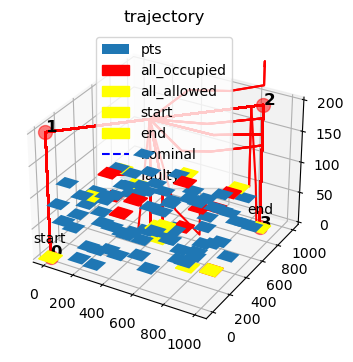

In [22]:
plot_env_with_traj3d(hists , mdl)

In [23]:
hists.get("nominal")

i.landed:                     array(301)
fxns.manage_health.m          array(301)
fxns.manage_health.m.mode:    array(301)
fxns.store_ee.ca.components.s1p1.s.soc: array(301)
fxns.store_ee.ca.com          array(301)
fxns.store_ee.ca.components.s1p1.s.e_t: array(301)
fxns.store_ee.ca.com          array(301)
fxns.store_ee.ca.com          array(301)
fxns.store_ee.ca.com          array(301)
fxns.store_ee.ca.com          array(301)
fxns.store_ee.ca.com          array(301)
fxns.store_ee.ca.com          array(301)
fxns.store_ee.s.soc:          array(301)
fxns.store_ee.m.faults.nocharge: array(301)
fxns.store_ee.m.faults.lowcharge: array(301)
fxns.store_ee.m.faults.s1p1_short: array(301)
fxns.store_ee.m.faults.s1p1_degr: array(301)
fxns.store_ee.m.faults.s1p1_break: array(301)
fxns.store_ee.m.faults.s1p1_nocharge: array(301)
fxns.store_ee.m.faults.s1p1_lowcharge: array(301)
fxns.store_ee.m.mode:         array(301)
fxns.dist_ee.s.ee_tr:         array(301)
fxns.dist_ee.s.ee_te:         array(301)

In [24]:
statsfmea = an.tabulate.fmea(endresults, app, group_by='fxnfault',
                            weight_metrics=['rate'],
                            avg_metrics=['unsafe_flight_time', 'cost', 'repcost',
                                         'landcost', 'body_strikes',
                                         'head_strikes', 'property_restrictions'],
                            sort_by='cost')
statsfmea

rate  unsafe_flight_time  \
affect_dof    rf_ctlbreak                 6.111111e-02          206.000000   
              lf_ctlbreak                 6.111111e-02          206.000000   
              lr_ctlbreak                 6.111111e-02          206.000000   
              rr_ctlbreak                 6.111111e-02          206.000000   
              rf_ctlup                    6.111111e-02          206.000000   
              lf_ctlup                    6.111111e-02          206.000000   
              rf_ctldn                    6.111111e-02          206.000000   
              lr_ctldn                    6.111111e-02          206.000000   
              lf_ctldn                    6.111111e-02          206.000000   
              lr_ctlup                    6.111111e-02          206.000000   
              rr_ctlup                    6.111111e-02          206.000000   
              rr_ctldn                    6.111111e-02          206.000000   
              rf_mechbreak                3.055556e-02          206.000000   
              lf_mechbreak                3.055556e-02          206.000000   
              lr_short                    3.055556e-02          206.000000   
              lf_short                    3.055556e-02          206.000000   
              lf_openc                    3.055556e-02          206.000000   
              rf_openc                    3.055556e-02          206.000000   
              rf_short                    3.055556e-02          206.000000   
              rr_short                    3.055556e-02          206.000000   
              lr_mechbreak                3.055556e-02          206.000000   
              rr_mechbreak                3.055556e-02          206.000000   
              rr_openc                    3.055556e-02          206.000000   
              lr_openc                    3.055556e-02          206.000000   
              lr_mechfriction             1.527778e-02          206.000000   
              rf_mechfriction             1.527778e-02          206.000000   
              rr_mechfriction             1.527778e-02          206.000000   
              lf_mechfriction             1.527778e-02          206.000000   
              lf_propbreak                9.166667e-03          206.000000   
              rf_propbreak                9.166667e-03          206.000000   
              lr_propbreak                9.166667e-03          206.000000   
              rr_propbreak                9.166667e-03          206.000000   
              lf_propstuck                6.111111e-03          206.000000   
              rf_propstuck                6.111111e-03          206.000000   
              rr_propstuck                6.111111e-03          206.000000   
              lr_propstuck                6.111111e-03          206.000000   
              rr_propwarp                 3.055556e-03          206.000000   
              rf_propwarp                 3.055556e-03          206.000000   
              lf_propwarp                 3.055556e-03          206.000000   
              lr_propwarp                 3.055556e-03          206.000000   
store_ee      lowcharge                   2.228333e-05          206.000000   
plan_path     vision_lack_of_detection    4.916667e-06          261.000000   
store_ee      s1p1_nocharge               1.912500e-05          206.000000   
              s1p1_lowcharge              1.271667e-05          206.000000   
              s1p1_short                  6.111111e-06          206.000000   
              s1p1_break                  6.111111e-06          206.000000   
              s1p1_degr                   6.111111e-06          206.000000   
dist_ee       degr                        1.694444e-06          227.666667   
store_ee      nocharge                    6.366667e-06          206.000000   
dist_ee       short                       1.016667e-06          227.666667   
              break                       6.777778e-07          227.6666